<a href="https://colab.research.google.com/github/Ahmad162539/ML-class-excercise-codes/blob/main/Hejran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IndexError: list index out of range

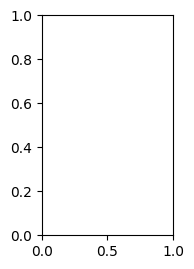

In [1]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
from keras.layers import GlobalMaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics.pairwise import linear_kernel
from glob import glob as glb


path=glb(".\images\\*.jpg")
# Plot samples
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path[i])
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

styles_df = pd.read_csv(".\styles.csv", nrows=296)
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
print(styles_df.shape)
print(styles_df.head(5))

plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

img_width, img_height, chnls = 100, 100, 3

#VGG16
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()

def img_path(img):

    return '.\images\\' + img

def predict(model, img_name):

    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

def get_embeddings(df, model):

    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

url=".\\images\\1995.jpg"
a = plt.imread(url)
plt.imshow(a)

sample_image = predict(vgg16_model, '1995.jpg')
sample_image.shape

df_sample_image = pd.DataFrame(sample_image)
print(df_sample_image)

sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

def get_similarity(model):

    sample_image = predict(vgg16_model, '1995.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

def normalize_sim(similarity):

    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

def get_recommendations(df, similarity):


    sim_scores = list(enumerate(similarity[0]))


    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


    sim_scores = sim_scores[0:5]
    print(sim_scores)

    cloth_indices = [i[0] for i in sim_scores]


    return df['image'].iloc[cloth_indices]

recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread('.\images\\'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()